In [19]:
import sqlite3
import geopandas
import pandas
import torch
import shapely.wkb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# connect to db
conn = sqlite3.connect('db.sqlite3')

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

class AirModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = torch.nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [17]:
# load Ingresos Programa de Salud Mental por mes y año for RM
# take the average per month
data = conn.execute("""
select sum(data.value) * 100000 / commune.population, unixepoch(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as unixepoch
from data
join report on data.report_id = report.id
join establishment on data.establishment_id = establishment.id
join commune on establishment.commune_id = commune.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
  and commune.name = 'PENALOLEN'
group by unixepoch
order by unixepoch
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['value', 'unixepoch']).drop(columns=['unixepoch'])
data

# # scale
scaler = StandardScaler()
data[["value"]] = scaler.fit_transform(data[["value"]])
data

,value
0,-0.295456
1,-1.110774
2,0.375982
3,0.535848
4,0.775647
...,...
76,-0.167563
77,-0.679135
78,0.216115
79,-0.199537


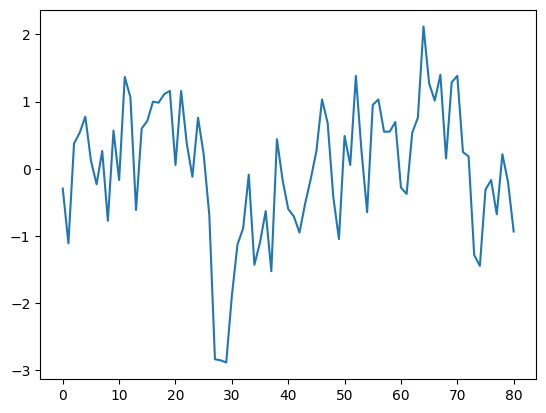

In [12]:
# plot
plt.plot(data['value'])

In [22]:
# test data
timeseries = data.values.astype('float32')
print(timeseries)

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = AirModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2001
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.xlabel('month')
plt.ylabel('Ingresos Programa de Salud Mental')
plt.legend(['data', 'train', 'test'])
plt.show()

[[-0.29545638]
 [-1.1107738 ]
 [ 0.37598154]
 [ 0.5358477 ]
 [ 0.775647  ]
 [ 0.12019568]
 [-0.2315099 ]
 [ 0.26407522]
 [-0.7750549 ]
 [ 0.56782097]
 [-0.16756342]
 [ 1.3671519 ]
 [ 1.0634061 ]
 [-0.6151887 ]
 [ 0.5997942 ]
 [ 0.7117005 ]
 [ 0.9994596 ]
 [ 0.983473  ]
 [ 1.1113659 ]
 [ 1.1593258 ]
 [ 0.05624921]
 [ 1.1593258 ]
 [ 0.37598154]
 [-0.11960358]
 [ 0.75966036]
 [ 0.21611539]
 [-0.69512177]
 [-2.8373284 ]
 [-2.853315  ]
 [-2.8852882 ]
 [-1.8941181 ]
 [-1.1267605 ]
 [-0.8869612 ]
 [-0.08763035]
 [-1.4305062 ]
 [-1.0947872 ]
 [-0.63117534]
 [-1.5264258 ]
 [ 0.43992803]
 [-0.16756342]
 [-0.5992021 ]
 [-0.7111084 ]
 [-0.95090765]
 [-0.519269  ]
 [-0.15157682]
 [ 0.26407522]
 [ 1.0314329 ]
 [ 0.67972726]
 [-0.4233493 ]
 [-1.0468273 ]
 [ 0.48788786]
 [ 0.05624921]
 [ 1.3831384 ]
 [ 0.26407522]
 [-0.64716196]
 [ 0.95149976]
 [ 1.0314329 ]
 [ 0.55183434]
 [ 0.55183434]
 [ 0.6957139 ]
 [-0.27946976]
 [-0.37538946]
 [ 0.5358477 ]
 [ 0.75966036]
 [ 2.118523  ]
 [ 1.2712321 ]
 [ 1.01544

/tmp/ipykernel_33983/386936367.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_33983/386936367.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 100: train RMSE 0.5046, test RMSE 1.1220
Epoch 200: train RMSE 0.4008, test RMSE 1.0810
Epoch 300: train RMSE 0.3700, test RMSE 1.0039
Epoch 400: train RMSE 0.3365, test RMSE 0.9439
Epoch 500: train RMSE 0.3123, test RMSE 0.9670
Epoch 600: train RMSE 0.2947, test RMSE 1.0045
Epoch 700: train RMSE 0.2967, test RMSE 1.0579


KeyboardInterrupt: 

/tmp/ipykernel_33983/3316292031.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))


Epoch 0: train RMSE 0.9898
Epoch 100: train RMSE 0.7654
Epoch 200: train RMSE 0.7381


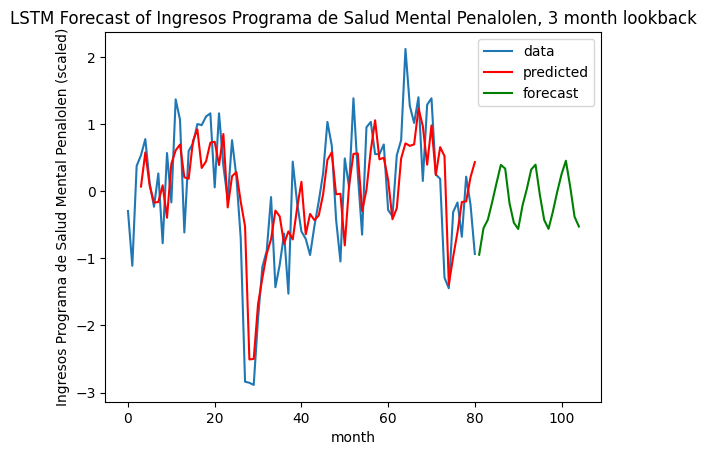

In [14]:
# full data and forecast
timeseries = data.values.astype('float32')

train_size = int(len(timeseries))

lookback = 3
X_train, y_train = create_dataset(timeseries, lookback=lookback)

model = AirModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 201
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
    print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    # forecast
    forecast_steps = 24
    input_seq = torch.tensor(timeseries[-lookback:]).unsqueeze(0)
    forecast = []
    for _ in range(forecast_steps):
        with torch.no_grad():
            next_val = model(input_seq)
        forecast.append(next_val[0, -1, 0].item())
        input_seq = torch.cat((input_seq[:, 1:, :], next_val[:, -1:, :]), dim=1)
    forecast = np.array(forecast)

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(range(len(timeseries), len(timeseries)+forecast_steps), forecast, c='g')
plt.title("LSTM Forecast of Ingresos Programa de Salud Mental Penalolen, 3 month lookback")
plt.xlabel('month')
plt.ylabel('Ingresos Programa de Salud Mental Penalolen (scaled)')
plt.legend(['data', 'predicted', 'forecast'])
plt.show()

/tmp/ipykernel_33983/1013765142.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))


Epoch 0: train RMSE 1.0115
Epoch 100: train RMSE 0.6170
Epoch 200: train RMSE 0.6003


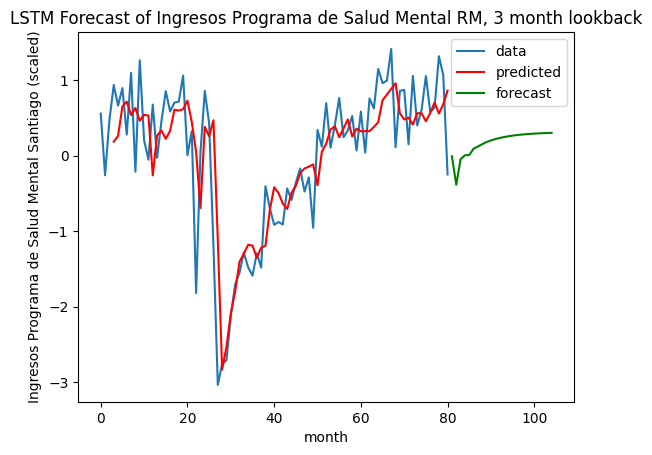

In [15]:
# RM
# load Ingresos Programa de Salud Mental por mes y año for RM
# take the average per month
data = conn.execute("""
select sum(data.value), unixepoch(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as unixepoch
from data
join report on data.report_id = report.id
join establishment on data.establishment_id = establishment.id
join commune on establishment.commune_id = commune.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
  and commune.region = 'REGION METROPOLITANA DE SANTIAGO'
group by unixepoch
order by unixepoch
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['value', 'unixepoch']).drop(columns=['unixepoch'])
data

# # scale
scaler = StandardScaler()
# scaler = StandardScaler()
data[["value"]] = scaler.fit_transform(data[["value"]])
data

# full data and forecast
timeseries = data.values.astype('float32')

train_size = int(len(timeseries))

lookback = 3
X_train, y_train = create_dataset(timeseries, lookback=lookback)

model = AirModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 201
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
    print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    # forecast
    forecast_steps = 24
    input_seq = torch.tensor(timeseries[-lookback:]).unsqueeze(0)
    forecast = []
    for _ in range(forecast_steps):
        with torch.no_grad():
            next_val = model(input_seq)
        forecast.append(next_val[0, -1, 0].item())
        input_seq = torch.cat((input_seq[:, 1:, :], next_val[:, -1:, :]), dim=1)
    forecast = np.array(forecast)

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(range(len(timeseries), len(timeseries)+forecast_steps), forecast, c='g')
plt.title("LSTM Forecast of Ingresos Programa de Salud Mental RM, 3 month lookback")
plt.xlabel('month')
plt.ylabel('Ingresos Programa de Salud Mental Santiago (scaled)')
plt.legend(['data', 'predicted', 'forecast'])
plt.show()